In [1]:
import numpy as np
import pandas as pd
import os
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('../mapillary_vistas_final_merged.csv')
df.shape

/home/nabeel/miniconda3/envs/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(28022, 34)

In [8]:
df = df[(df['final_shape'] == 'octagon-915.0')]
# filenames_concat = []
# tgt_concat = []
# dims_concat = []
# for index, row in df.iterrows():
#     if not pd.isna(row['points']):
#         tgt = np.array(literal_eval(row['points']), dtype=np.float32)
#     elif not pd.isna(row['tgt_polygon']):
#         tgt = np.array(literal_eval(row['tgt_polygon']), dtype=np.float32)
#     else:
#         tgt = np.array(literal_eval(row['tgt']), dtype=np.float32)
#     tgt_concat.append(tgt)
#     dims_concat.append(np.array([max(tgt[:,0]) - min(tgt[:,0]), max(tgt[:,1]) - min(tgt[:,1])]))

# tgt_concat = np.array(tgt_concat)
# dims_concat = np.array(dims_concat)
# tgt_concat.shape

def get_tgt_and_tgt_dimensions(row):
    if not pd.isna(row['points']):
        tgt = np.array(literal_eval(row['points']), dtype=np.float32)
    elif not pd.isna(row['tgt_polygon']):
        tgt = np.array(literal_eval(row['tgt_polygon']), dtype=np.float32)
    else:
        tgt = np.array(literal_eval(row['tgt']), dtype=np.float32)
    return np.array([max(tgt[:,0]) - min(tgt[:,0]), max(tgt[:,1]) - min(tgt[:,1])])

df['dims'] = df.apply(get_tgt_and_tgt_dimensions, axis=1)
df['dims_x'] = df.apply(lambda row: row['dims'][0], axis=1)
df['dims_y'] = df.apply(lambda row: row['dims'][1], axis=1)
df['tgt_area'] = df.apply(lambda row: row['dims'][0]*row['dims'][1], axis=1)
# df[['filename', 'filename_y', 'tgt_final', 'dims', 'dims_x', 'tgt_area']]

dimensions_df = pd.DataFrame(columns=['filename', 'filename_y', 'dims'])
dimensions_df_filenames = []
dimensions_df_dims = []

for filename in df['filename_y'].unique():
    tmp_df = df[df['filename_y'] == filename]
    tmp_df = tmp_df.sort_values(by=['tgt_area'], ascending=False)
    dimensions_df_filenames.append(filename)
    dimensions_df_dims.append(tmp_df.iloc[0]['dims'])
dimensions_df['filename'] = dimensions_df_filenames
dimensions_df['dims'] = dimensions_df_dims
dimensions_df['dims_x'] = dimensions_df.apply(lambda row: row['dims'][0], axis=1)
dimensions_df['dims_y'] = dimensions_df.apply(lambda row: row['dims'][1], axis=1)
dimensions_df



,filename,filename_y,dims,dims_x,dims_y
0,J-8nlLTMRhKGH1lokswIzQ.jpg,NaN,"[57.142822, 57.142822]",57.142822,57.142822
1,04_G_l3AleUQWBSJ4_R8Hw.jpg,NaN,"[33.98694, 145.09804]",33.986938,145.098038
2,0UTXK-0rPSKXTenLg9ibeg.jpg,NaN,"[126.086914, 124.3479]",126.086914,124.347900
3,5vH7bvOMCAtbsEAeOfE77Q.jpg,NaN,"[103.93701, 97.63782]",103.937012,97.637817
4,LGAYKU4VpFMKY-W9tRyRCw.jpg,NaN,"[126.086914, 118.260864]",126.086914,118.260864
...,...,...,...,...,...
501,niLvh78xKkuoR216YCTIyg.jpg,NaN,"[83.0, 83.0]",83.000000,83.000000
502,oy92EU5n38HppHoMBDHAIw.jpg,NaN,"[142.0, 136.0]",142.000000,136.000000
503,xplR-2-JZioNw-wndJoFJQ.jpg,NaN,"[45.0, 46.0]",45.000000,46.000000
504,Y2_AjNDiZPFRKv205TvqmA.jpg,NaN,"[169.0, 151.0]",169.000000,151.000000


In [9]:
df.groupby(by=['filename_y']).mean().reset_index().shape

(506, 26)

In [10]:
df = pd.read_csv('../runs/results.csv')
df = df.replace({'apply_patch': 'True', 'random_patch': 'True'}, 1)
df = df.replace({'apply_patch': 'False', 'random_patch': 'False'}, 0)
for col in ['apply_patch', 'random_patch']:
    df[col] = df[col].astype(float).astype(bool)

# transforms_applied = [None] + [(True, True)] * 4 +  [(False, True)] * 4 + [(True, False)] * 2 + [(False, False)] * 1
# df['(transform, relighting) when testing patch'] = transforms_applied
# df[['fnr_octagon', 'num_octagon_labels', 'num_octagon_with_patch', 'fn_octagon', 'apply_patch', 'generate_patch', 'rescaling', 'relighting', '(transform, relighting) when testing patch']]

df[['fnr_octagon', 'num_octagon_labels', 'num_octagon_with_patch', 'fn_octagon', 'apply_patch', 'generate_patch', 'rescaling', 'relighting']]

# 0     -> no patch on stop signs
# 1-4   -> rp2 patch WITH transform and WITH relighting
# 5-8   -> rp2 patch WITHOUT transform and WITH relighting
# 9-10  -> rp2 patch WITH transform and WITHOUT relighting
# 10-11 -> rp2 patch WITHOUT transform and WITHOUT relighting

# generate_patch == 'synthetic' -> means the patch was GENERATED on the synthetic dataset
# rescaling == True -> means the stop signs were resized during patch GENERATION
# relighting == True -> means the stop signs were relighted (changed brightness and contrast) during patch GENERATION

,fnr_octagon,num_octagon_labels,num_octagon_with_patch,fn_octagon,apply_patch,generate_patch,rescaling,relighting
0,0.206545,885.0,0.0,183.0,False,NaN,NaN,NaN
1,0.249718,885.0,571.0,221.0,True,synthetic,0.0,0.0
2,0.248588,885.0,571.0,220.0,True,synthetic,True,False
3,0.247458,885.0,571.0,219.0,True,synthetic,False,True
4,0.249718,885.0,571.0,221.0,True,synthetic,True,True
5,0.254237,885.0,571.0,225.0,True,synthetic,False,False
6,0.251977,885.0,571.0,223.0,True,synthetic,True,False
7,0.253449,885.0,571.0,224.0,True,synthetic,False,True
8,0.251977,885.0,571.0,223.0,True,synthetic,True,True
9,0.249718,885.0,571.0,221.0,True,synthetic,False,False


In [41]:
success_rates = [None]
for exp_num in range(0, len(df)-1):
    no_patch_df = pd.read_csv('../runs/val/exp_mapillary_no_patch_0/results_per_image.csv')
    no_patch_df = no_patch_df.drop(columns=['fnr'])
    assert(len(no_patch_df[no_patch_df['num_octagons'] < no_patch_df['num_patches']]) == 0)

    patch_df = pd.read_csv(f'../runs/val/exp_mapillary_rp2_patch_{exp_num}/results_per_image.csv')
    patch_df = patch_df.drop(columns=['fnr'])

    assert(len(patch_df[patch_df['num_octagons'] < patch_df['num_patches']]) == 0)
    merged_df = no_patch_df.merge(patch_df, on='filename', suffixes=['_no_patch', '_patch'])

    merged_df['change_in_fn'] = merged_df['fn_patch'] - merged_df['fn_no_patch']
    merged_df = merged_df.sort_values(by=['change_in_fn', 'filename'], ascending=[False, True])

    total_change_in_fn = np.sum(merged_df['change_in_fn'])
    num_patches = np.sum(merged_df['num_patches_patch'])
    success_rate = np.round(total_change_in_fn/num_patches, 3)
    # print('change in false negatives:', total_change_in_fn)
    # print('num patches:', num_patches)
    # print('success rate:', success_rate)
    # print()
    success_rates.append(success_rate)

df['success_rate'] = success_rates
# df[['fnr_octagon', 'num_octagon_labels', 'num_octagon_with_patch', 'fn_octagon', 'apply_patch', 'generate_patch', 'rescaling', 'relighting', 'success_rate']]

transforms_applied = [None] + [(True, True)] * 4 +  [(False, True)] * 4 + [(True, False)] * 2 + [(False, False)] * 1
df['(transform, relighting) when testing patch'] = transforms_applied
df[['fnr_octagon', 'num_octagon_labels', 'num_octagon_with_patch', 'fn_octagon', 'apply_patch', 'generate_patch', 'rescaling', 'relighting', '(transform, relighting) when testing patch', 'success_rate']]

# 0     -> no patch on stop signs
# 1-4   -> rp2 patch WITH transform and WITH relighting
# 5-8   -> rp2 patch WITHOUT transform and WITH relighting
# 9-10  -> rp2 patch WITH transform and WITHOUT relighting
# 10-11 -> rp2 patch WITHOUT transform and WITHOUT relighting

# generate_patch == 'synthetic' -> means the patch was GENERATED on the synthetic dataset
# rescaling == True -> means the stop signs were resized during patch GENERATION
# relighting == True -> means the stop signs were relighted (changed brightness and contrast) during patch GENERATION


,fnr_octagon,num_octagon_labels,num_octagon_with_patch,fn_octagon,apply_patch,generate_patch,rescaling,relighting,"(transform, relighting) when testing patch",success_rate
0,0.206545,885.0,0.0,183.0,False,NaN,NaN,NaN,None,NaN
1,0.249718,885.0,571.0,221.0,True,synthetic,0.0,0.0,"(True, True)",0.067
2,0.248588,885.0,571.0,220.0,True,synthetic,True,False,"(True, True)",0.065
3,0.247458,885.0,571.0,219.0,True,synthetic,False,True,"(True, True)",0.063
4,0.249718,885.0,571.0,221.0,True,synthetic,True,True,"(True, True)",0.067
5,0.254237,885.0,571.0,225.0,True,synthetic,False,False,"(False, True)",0.074
6,0.251977,885.0,571.0,223.0,True,synthetic,True,False,"(False, True)",0.070
7,0.253449,885.0,571.0,224.0,True,synthetic,False,True,"(False, True)",0.072
8,0.251977,885.0,571.0,223.0,True,synthetic,True,True,"(False, True)",0.070
9,0.249718,885.0,571.0,221.0,True,synthetic,False,False,"(True, False)",0.067


In [55]:
no_patch_df = pd.read_csv('../runs/val/exp_mapillary_no_patch_0/results_per_image.csv')
no_patch_df = no_patch_df.drop(columns=['fnr'])
assert(len(no_patch_df[no_patch_df['num_octagons'] < no_patch_df['num_patches']]) == 0)
patch_df = pd.read_csv('../runs/val/exp_mapillary_rp2_patch_0/results_per_image.csv')
patch_df = patch_df.drop(columns=['fnr'])
assert(len(patch_df[patch_df['num_octagons'] < patch_df['num_patches']]) == 0)
merged_df = no_patch_df.merge(patch_df, on='filename', suffixes=['_no_patch', '_patch'])
merged_df['change_in_fn'] = merged_df['fn_patch'] - merged_df['fn_no_patch']
merged_df = merged_df.sort_values(by=['change_in_fn', 'filename'], ascending=[False, True])
successful_attack_filenames_1 = set(merged_df[merged_df['change_in_fn'] > 0]['filename'])
len(successful_attack_filenames_1)

39

In [60]:
no_patch_df = pd.read_csv('../runs/val/exp_mapillary_no_patch_0/results_per_image.csv')
no_patch_df = no_patch_df.drop(columns=['fnr'])
assert(len(no_patch_df[no_patch_df['num_octagons'] < no_patch_df['num_patches']]) == 0)
patch_df = pd.read_csv('../runs/val/exp_mapillary_rp2_patch_14/results_per_image.csv')
patch_df = patch_df.drop(columns=['fnr'])
assert(len(patch_df[patch_df['num_octagons'] < patch_df['num_patches']]) == 0)
merged_df = no_patch_df.merge(patch_df, on='filename', suffixes=['_no_patch', '_patch'])
merged_df['change_in_fn'] = merged_df['fn_patch'] - merged_df['fn_no_patch']
merged_df = merged_df.sort_values(by=['change_in_fn', 'filename'], ascending=[False, True])
successful_attack_filenames_2 = set(merged_df[merged_df['change_in_fn'] > 0]['filename'])
len(successful_attack_filenames_2)

12

In [61]:
merged_df = merged_df.merge(dimensions_df, on='filename', how='right')
merged_df['success'] = merged_df['fn_patch'] > merged_df['fn_no_patch']
merged_df

,filename,num_octagons_no_patch,num_patches_no_patch,fn_no_patch,num_octagons_patch,num_patches_patch,fn_patch,change_in_fn,filename_y,dims,dims_x,dims_y,success
0,J-8nlLTMRhKGH1lokswIzQ.jpg,7,0.0,1,7,5.0,0,-1,NaN,"[57.142822, 57.142822]",57.142822,57.142822,False
1,04_G_l3AleUQWBSJ4_R8Hw.jpg,1,0.0,0,1,1.0,0,0,NaN,"[33.98694, 145.09804]",33.986938,145.098038,False
2,0UTXK-0rPSKXTenLg9ibeg.jpg,3,0.0,1,3,2.0,1,0,NaN,"[126.086914, 124.3479]",126.086914,124.347900,False
3,5vH7bvOMCAtbsEAeOfE77Q.jpg,1,0.0,0,1,1.0,0,0,NaN,"[103.93701, 97.63782]",103.937012,97.637817,False
4,LGAYKU4VpFMKY-W9tRyRCw.jpg,1,0.0,0,1,1.0,0,0,NaN,"[126.086914, 118.260864]",126.086914,118.260864,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,niLvh78xKkuoR216YCTIyg.jpg,1,0.0,0,1,1.0,0,0,NaN,"[83.0, 83.0]",83.000000,83.000000,False
502,oy92EU5n38HppHoMBDHAIw.jpg,1,0.0,1,1,1.0,1,0,NaN,"[142.0, 136.0]",142.000000,136.000000,False
503,xplR-2-JZioNw-wndJoFJQ.jpg,2,0.0,1,2,2.0,1,0,NaN,"[45.0, 46.0]",45.000000,46.000000,False
504,Y2_AjNDiZPFRKv205TvqmA.jpg,1,0.0,0,1,1.0,0,0,NaN,"[169.0, 151.0]",169.000000,151.000000,False


In [62]:
np.sum(merged_df['success'])

12

<AxesSubplot:xlabel='dims_x', ylabel='dims_y'>

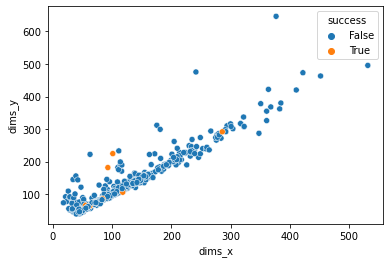

In [64]:
sns.scatterplot(x='dims_x', y='dims_y', data=merged_df, hue='success')

In [30]:
successful_attack_filenames = successful_attack_filenames_1.intersection(successful_attack_filenames_2)
print(len(successful_attack_filenames))
successful_attack_filenames

27


{'-9KGl9SjjCNY1k7e7kZAQw.jpg',
 '2EG-9qqAB81t0bjWF0iS9Q.jpg',
 '2Nvhp5duIvb-OYY7xAMwZw.jpg',
 '2SYXukg_XcwH7F-6qHAXDg.jpg',
 '2_Fnzu8YIZ6zSI348MosAA.jpg',
 '47yDC2IeDHcYjmx84kySNg.jpg',
 '5UIDjjCd-ZX6kIIlUIqY-A.jpg',
 '8lkcFc59-2RgSU203mlYEQ.jpg',
 'Bk56TB3UXwQPPpI3l5DE8A.jpg',
 'Rnd44l5YT6De9xazPe5gog.jpg',
 'Tji-mT9uSpJBrkpgiOYh0w.jpg',
 'UATnqpo1FEgpkYhLKKSFOQ.jpg',
 'WZW-sT3UBZNIhS33ABGtRA.jpg',
 'XrOIVvWi3cybs5eoA5TWAg.jpg',
 'Y2V2xZLzeTGMNM0JWqwGNQ.jpg',
 'ZRJFX8E6ls076pkO1-_mqg.jpg',
 '_iN9KqCNguVQqoSlHTSAbA.jpg',
 '_zyWmZg0lfs_VV3eGc3fRQ.jpg',
 'cp2b41bAzpc3pz2hDU3_tA.jpg',
 'dudfDGkgKVvU6svtnV4MOA.jpg',
 'j5SRLeWOR4sCr6UnrNLDeQ.jpg',
 'lQXJRin862diB-ycBEI07Q.jpg',
 'lS2eAyh4pLjSrBx6AoCkTw.jpg',
 'sVfs9ru80iIlDilXAtjDkg.jpg',
 'tNm0eslf8vm0zO8_2I-XWg.jpg',
 'v6qkSgVYFmNbitJMGWmGiA.jpg',
 'xplR-2-JZioNw-wndJoFJQ.jpg'}

Text(0, 0.5, 'fnr')

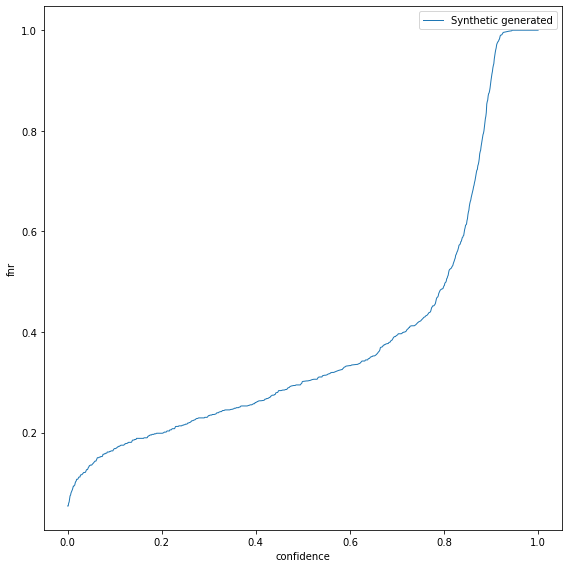

In [32]:
with open('../x_axis.npy', 'rb') as f:
    x_axis = np.load(f)
fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
with open('../runs/val/exp_mapillary_rp2_patch_0/FNR_curve_octagon.npy', 'rb') as f:
    fnr = np.load(f)
ax.plot(x_axis, fnr, linewidth=1, label=f'synthetic generated')

ax.legend()
ax.set_xlabel('confidence')
ax.set_ylabel('fnr')

In [ ]:
df = pd.read_csv('../runs/results_.csv')
df = df.replace({'apply_patch': 'True', 'random_patch': 'True'}, 1)
df = df.replace({'apply_patch': 'False', 'random_patch': 'False'}, 0)
df['apply_patch'] = df['apply_patch'].astype(float).astype(bool)
df['random_patch'] = df['random_patch'].astype(float).astype(bool)
df.head(6)

In [ ]:
df['apply_patch_and_random_patch'] = list(zip(df['apply_patch'], df['random_patch']))
order_list = [(False, False), (True, True), (True, False)]

fig, axes = plt.subplots(1, 4, figsize=(20, 5), squeeze=False)
axes[0, 0].set_title('mapillary mAP@0.5')
axes[0, 1].set_title('mapillary synthetic sign AP@0.5')
axes[0, 2].set_title('mapillary synthetic sign AP@0.5:0.95')
axes[0, 3].set_title('mapillary blue circle AP@0.5')

axes[0, 0].set_yticks(ticks=np.arange(0, 1, 0.05))
axes[0, 1].set_yticks(ticks=np.arange(0, 1, 0.05))
axes[0, 2].set_yticks(ticks=np.arange(0, 1, 0.05))
axes[0, 3].set_yticks(ticks=np.arange(0, 1, 0.05))

sns.barplot(x="apply_patch_and_random_patch", y="map_50_all", data=df[df['dataset']=='mapillary'], ax=axes[0, 0], order=order_list)
sns.barplot(x="apply_patch_and_random_patch", y="ap_50_synthetic_stop_sign", data=df[df['dataset']=='mapillary'], ax=axes[0, 1], order=order_list)
sns.barplot(x="apply_patch_and_random_patch", y="ap_50_95_synthetic_stop_sign", data=df[df['dataset']=='mapillary'], ax=axes[0, 2], order=order_list)
sns.barplot(x="apply_patch_and_random_patch", y="ap_50_circle-blue", data=df[df['dataset']=='mapillary'], ax=axes[0, 3], order=order_list)


# axes[1, 0].set_title('mtsd mAP@0.5')
# axes[1, 1].set_title('mtsd synthetic sign AP@0.5')
# axes[1, 2].set_title('mtsd synthetic sign AP@0.5:0.95')
# sns.barplot(x="apply_patch_and_random_patch", y="map_50_all", data=df[df['dataset']=='mtsd'], ax=axes[1, 0], order=order_list)
# sns.barplot(x="apply_patch_and_random_patch", y="ap_50_synthetic_stop_sign", data=df[df['dataset']=='mtsd'], ax=axes[1, 1], order=order_list)
# sns.barplot(x="apply_patch_and_random_patch", y="ap_50_95_synthetic_stop_sign", data=df[df['dataset']=='mtsd'], ax=axes[1, 2], order=order_list)
